In [47]:
import pandas as pd
import numpy as np
import os
import datetime
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from scipy import stats
from google.cloud import bigquery
from google.oauth2 import service_account
import seaborn as sns
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')
import matplotlib
matplotlib.style.use('ggplot')

os.chdir(r'C:\Users\Akshay Gupta\Documents\Projects\Homescape\Vizualisations\Config')

### TUYA Device Data

In [48]:
# credentials = service_account.Credentials.from_service_account_file('bigqueryauth.json')
# project_id = 'solar-222307'
# client = bigquery.Client(credentials= credentials,project=project_id)

# query_job = client.query("""
# select * from dev_loggers.tuya 
# where event_time_utc>'2020-11-27'
# """)
# tuya_data = query_job.result().to_dataframe() 

# tuya_data['value']=tuya_data['value'].replace('true','1').replace('false','0')
# tuya_data['value']=tuya_data['value'].astype(float)
# tuya_data['event_time_utc']=pd.to_datetime(tuya_data['event_time_utc'])
# tuya_data=tuya_data.drop_duplicates(subset=['device_id','event_timestamp','code','value'])


# pivot_data=tuya_data.pivot_table(index=['property_id','device_id','event_time_utc'], columns='code', values='value')
# pivot_data=pivot_data.reset_index()
# pivot_data['Date']=[i.date() for i in pivot_data['event_time_utc']]

# for i,j in pivot_data[['device_id','property_id']].drop_duplicates().itertuples(index=False):
#     pivot_data.loc[(pivot_data.device_id==i) & (pivot_data.property_id==j), 'cur_voltage']=pivot_data.loc[(pivot_data.device_id==i) & (pivot_data.property_id==j), 'cur_voltage'].fillna(method='ffill')
#     pivot_data.loc[(pivot_data.device_id==i) & (pivot_data.property_id==j), 'cur_power']=pivot_data.loc[(pivot_data.device_id==i) & (pivot_data.property_id==j), 'cur_power'].fillna(method='ffill')
#     pivot_data.loc[(pivot_data.device_id==i) & (pivot_data.property_id==j), 'cur_current']=pivot_data.loc[(pivot_data.device_id==i) & (pivot_data.property_id==j), 'cur_current'].fillna(method='ffill')
    

# pivot_data['Month'] = [i.month for i in pivot_data['event_time_utc']]
# pivot_data['Week'] = [i.week for i in pivot_data['event_time_utc']]
# pivot_data['Year'] = [i.year for i in pivot_data['event_time_utc']]

# os.chdir(r"C:\Users\Akshay Gupta\Documents\Projects\Homescape\OnSet\Data")
# pivot_data.to_csv("Tuya_Data.csv")

# query_job = client.query("""
# select * from loggers.onset
# where logged_time_local>'2020-12-25'
# """)

# results = query_job.result().to_dataframe() # Wait for the job to complete.

# results.to_csv("onset_data_temp.csv")

In [49]:
os.chdir(r"C:\Users\Akshay Gupta\Documents\Projects\Homescape\OnSet\Data")
tuya_data=pd.read_csv("Tuya_Data.csv")
onset_data=pd.read_csv("onset_data_temp.csv")
onset_data.logged_time_local=pd.to_datetime(onset_data.logged_time_local)
onset_data['logged_time_local']=onset_data['logged_time_local']-datetime.timedelta(hours=5.5)
onset_data=onset_data.set_index('logged_time_local').sort_index()
tuya_data['event_time_utc']=pd.to_datetime(tuya_data['event_time_utc'])
tuya_data=tuya_data.set_index('event_time_utc')
onset_data=onset_data[pd.to_datetime(onset_data.index) >= pd.to_datetime('2020-12-02 15:30:00')]

In [50]:
len(onset_data)

300445

In [51]:
onset_data['before_mean']=onset_data['mains_power'].rolling(5).mean()
onset_data['before_max']=onset_data['mains_power'].abs().rolling(5).max()
onset_data['after_mean']=0
onset_data['after_max']=0
onset_data['per_change']=0
onset_data['time_spent']=0

In [52]:
per_change=[]
after_mean=[]
after_max=[]
events=[]
for i in range(3,len(onset_data)-3):
    change=100*(onset_data['before_mean'].iloc[i+3]-onset_data['before_mean'].iloc[i-1])/onset_data['before_mean'].iloc[i+3]
    per_change.append(change)
    after_mean.append(onset_data['before_mean'].iloc[i+3])
    after_max.append(onset_data['before_max'].iloc[i+3])
    if abs(change)>5:
        events.append(onset_data['mains_power'].iloc[i])
    else:
        events.append(0)

In [53]:
onset_data['per_change'].iloc[3:-3]=per_change
onset_data['after_mean'].iloc[3:-3]=after_mean
onset_data['after_max'].iloc[3:-3]=after_max
onset_data['avg_diff']=onset_data['after_mean']-onset_data['before_mean']
onset_data['avg_diff']=onset_data['after_mean']-onset_data['before_mean']

In [54]:
onset_data[(onset_data['mains_power']<=.07) & (onset_data['property_id']!=20)].sort_index()

,Unnamed: 0,property_id,timestamp,use,gen,l1_voltage,l2_voltage,l3_voltage,l1_frequency,l2_frequency,...,thd,thd_l2,dump,before_mean,before_max,after_mean,after_max,per_change,time_spent,avg_diff
logged_time_local,,,,,,,,,,,,,,,,,,,,,
2020-12-24 20:37:00,121963,1403,1.608862e+09,0.063794,0.0,77.028057,79.849028,79.810694,16.276952,16.277270,...,0.908452,0.753738,NaN,0.169559,0.197000,0.129959,0.199,-50.817109,0,-0.039600
2020-12-24 20:39:06,121277,1403,1.608862e+09,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,NaN,0.130359,0.197000,0.130559,0.199,-29.871614,0,0.000200
2020-12-24 21:17:01,121276,1403,1.608864e+09,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,NaN,0.134548,0.190067,0.099534,0.198,-73.354854,0,-0.035013
2020-12-24 21:17:02,121278,1403,1.608864e+09,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,NaN,0.096548,0.190067,0.119000,0.200,-13.065344,0,0.022452
2020-12-25 08:45:48,127644,1403,1.608906e+09,0.059000,0.0,233.785004,240.839005,240.621017,164.941010,49.949001,...,83.556007,2.595000,NaN,0.072200,0.076000,0.062800,0.075,-20.382166,0,-0.009400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-25 09:04:08,212063,1403,1.608907e+09,0.059000,0.0,231.395004,238.207016,240.798004,145.598007,86.855003,...,62.883003,52.841003,NaN,0.057800,0.059000,0.058000,0.059,0.689655,0,0.000200
2020-12-25 09:04:09,177437,1403,1.608907e+09,0.056000,0.0,231.335007,238.253006,240.994019,155.558014,80.970001,...,40.956001,37.835003,NaN,0.057400,0.059000,0.057400,0.059,-0.696864,0,0.000000
2020-12-25 09:04:10,174322,1403,1.608907e+09,0.058000,0.0,231.449005,238.031006,240.935013,134.563004,85.837006,...,65.866005,51.599003,NaN,0.057400,0.059000,0.290400,1.224,80.234160,0,0.233000


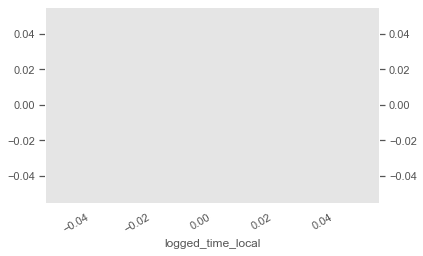

In [55]:
stdate=pd.to_datetime('2020-12-02 16:50:30')
enddate=pd.to_datetime('2020-12-02 16:59:30')

fig,ax=plt.subplots()
ax2=ax.twinx()
onset_data[(pd.to_datetime(onset_data.index)<= enddate) & (pd.to_datetime(onset_data.index)>= stdate)]['avg_diff'].plot(ax=ax2,color='blue')
onset_data[(pd.to_datetime(onset_data.index)<= enddate) & (pd.to_datetime(onset_data.index)>= stdate)]['mains_power'].plot(ax=ax,color='red')
# onset_data[(pd.to_datetime(onset_data.index)<= enddate) & (pd.to_datetime(onset_data.index)>= stdate)]['per_change_current'].plot(ax=ax2,color='green')
ax.grid('')
ax2.grid('')


# fig,ax=plt.subplots()
# ax2=ax.twinx()
# data['percent_change'][1500:2000].plot(ax=ax2,color='blue')
# data['mains_power'][1500:2000].plot(ax=ax,color='red')
# ax.grid('')
# ax2.grid('')


In [56]:
onset_data[(pd.to_datetime(onset_data.index)<= enddate) & (pd.to_datetime(onset_data.index)>= stdate)]

,Unnamed: 0,property_id,timestamp,use,gen,l1_voltage,l2_voltage,l3_voltage,l1_frequency,l2_frequency,...,thd,thd_l2,dump,before_mean,before_max,after_mean,after_max,per_change,time_spent,avg_diff
logged_time_local,,,,,,,,,,,,,,,,,,,,,


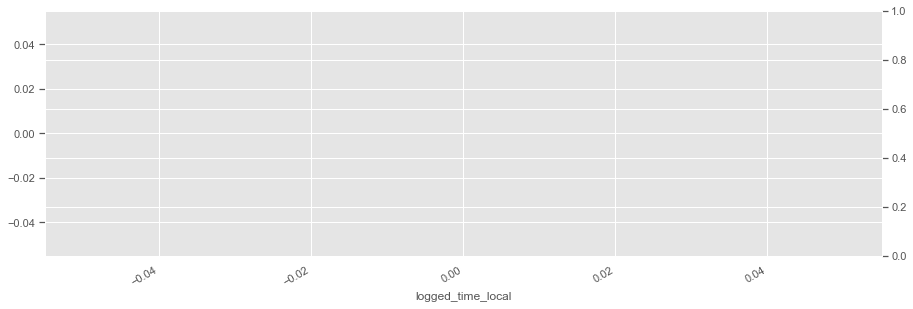

In [57]:
fig,ax=plt.subplots()
ax2=ax.twinx()
fig.set_size_inches(15,5)
stdate=pd.to_datetime('2020-12-20 02:45:00')
enddate=pd.to_datetime('2020-12-20 02:51:00')
onset_data[(pd.to_datetime(onset_data.index)<= enddate) & (pd.to_datetime(onset_data.index)>= stdate)]['before_mean'].plot(ax=ax,color='red')
# onset_data[(pd.to_datetime(onset_data.index)<= enddate) & (pd.to_datetime(onset_data.index)>= stdate)]['events'].plot(ax=ax2,color='blue')
onset_data[(pd.to_datetime(onset_data.index)<= enddate) & (pd.to_datetime(onset_data.index)>= stdate)]['mains_power'].plot(ax=ax,color='green')

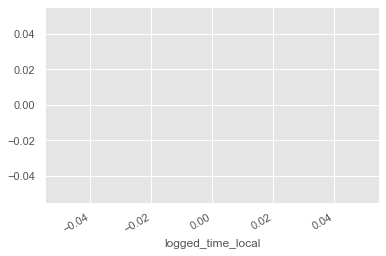

In [58]:
onset_data['events']=False
onset_data[(pd.to_datetime(onset_data.index)<= enddate) & (pd.to_datetime(onset_data.index)>= stdate) & (abs(onset_data['avg_diff'])>.01)]['after_mean'].plot(ms=2,marker='*')

In [59]:
onset_data.loc[(pd.to_datetime(onset_data.index)<= enddate) & (pd.to_datetime(onset_data.index)>= stdate) & (abs(onset_data['avg_diff'])>.01), 'events']=True
onset_data.loc[(pd.to_datetime(onset_data.index)<= enddate) & (pd.to_datetime(onset_data.index)>= stdate) & (abs(onset_data['avg_diff'])>.01)]

,Unnamed: 0,property_id,timestamp,use,gen,l1_voltage,l2_voltage,l3_voltage,l1_frequency,l2_frequency,...,thd_l2,dump,before_mean,before_max,after_mean,after_max,per_change,time_spent,avg_diff,events
logged_time_local,,,,,,,,,,,,,,,,,,,,,


In [60]:
temp_data=onset_data[(pd.to_datetime(onset_data.index)<= enddate) & (pd.to_datetime(onset_data.index)>= stdate)]

#### transition start=1, transition= 2, transition end=3, steady=0
temp_data.loc[temp_data['events']==True,'event_type']=2
temp_data.loc[temp_data['events']==False,'event_type']=0

ValueError: cannot set a frame with no defined index and a scalar

In [ ]:
temp_data['event_effect']=0
prev_state=0
event_mean_before=0
for i in range(len(temp_data)):
    if temp_data['events'].iloc[i]==0:
        if prev_state==1:
            temp_data['event_type'].iloc[i]=3
            temp_data['event_effect'].iloc[i-1]=temp_data['after_mean'].iloc[i-1]-event_mean_before
            event_mean_before=temp_data['before_mean'].iloc[i-1]
        prev_state=0
    else:
        if prev_state==0:
            temp_data['event_type'].iloc[i+2]=1
            temp_data['event_effect'].iloc[i-1]=temp_data['after_mean'].iloc[i-1]-event_mean_before
            event_mean_before=temp_data['before_mean'].iloc[i-1]
        prev_state=1
        


In [ ]:
temp_data.pivot_table(index='event_type', aggfunc='count')
# (temp_data['event_effect']!=0).sum()

In [ ]:
temp_data2=temp_data[temp_data['event_type'].isin([1])]
fig,ax=plt.subplots()
# ax2=ax.twinx()
fig.set_size_inches(15,5)
ax.scatter(temp_data2.index,temp_data2.mains_power,c=temp_data2.event_type, s=15)
ax.plot(temp_data.index,temp_data.mains_power)
# ax.plot(temp_data.index[temp_data['event_effect']!=0],temp_data.event_effect[temp_data['event_effect']!=0], color='green',lw=0,ms=5,marker='o')

In [ ]:
temp_data.pivot_table(index='event_type', aggfunc='count')

In [ ]:
stdate=pd.to_datetime('2020-12-20 10:00:00')
enddate=pd.to_datetime('2020-12-20 11:00:00')
onset_data.loc[(pd.to_datetime(onset_data.index)<= enddate) & (pd.to_datetime(onset_data.index)>= stdate) & (abs(onset_data['avg_diff'])>.01), 'events']=True
temp_data=onset_data[(pd.to_datetime(onset_data.index)<= enddate) & (pd.to_datetime(onset_data.index)>= stdate)]

temp_data['event_type']=0

#### transition start=1, transition= 2, transition end=3, steady=0
temp_data.loc[temp_data['events']==True,'event_type']=2
temp_data.loc[temp_data['events']==False,'event_type']=0

temp_data['event_effect']=0
prev_state=0
event_mean_before=0
for i in range(len(temp_data)):
    if temp_data['events'].iloc[i]==0:
        if prev_state==1:
            temp_data['event_type'].iloc[i]=3
            temp_data['event_effect'].iloc[i-1]=temp_data['after_mean'].iloc[i-1]-event_mean_before
            event_mean_before=temp_data['before_mean'].iloc[i-1]
        prev_state=0
    else:
        if prev_state==0:
            temp_data['event_type'].iloc[i+1]=1
            temp_data['event_effect'].iloc[i-1]=temp_data['after_mean'].iloc[i-1]-event_mean_before
            event_mean_before=temp_data['before_mean'].iloc[i-1]
        prev_state=1

In [ ]:
temp_data2=temp_data[temp_data['event_type'].isin([1])]
fig,ax=plt.subplots()
# ax2=ax.twinx()
fig.set_size_inches(15,5)
tuya_data
ax.scatter(temp_data2.index,temp_data2.mains_power,c=temp_data2.event_type, s=15)
ax.plot(temp_data.index,temp_data.mains_power)

In [ ]:
temp_data['event_type'].unique()

In [ ]:
tuya_data[(pd.to_datetime(tuya_data.index)<= enddate) & (pd.to_datetime(tuya_data.index)>= stdate)].switch_1